In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, models
import os
import matplotlib.pyplot as plt

2025-04-02 01:08:58.535937: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


2025-04-02 01:09:05.395230: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-04-02 01:09:05.454625: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-04-02 01:09:05.454783: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-04-02 01:09:05.456236: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compi

Epoch 1/100


2025-04-02 01:09:08.024966: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2025-04-02 01:09:11.327342: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


772/772 [==============================] - 140s 174ms/step - loss: 0.1051 - mae: 0.2235 - val_loss: 0.0972 - val_mae: 0.2099 - lr: 1.9531e-06
Epoch 2/100
772/772 [==============================] - 116s 150ms/step - loss: 0.1034 - mae: 0.2225 - val_loss: 0.0927 - val_mae: 0.2048 - lr: 1.9531e-06
Epoch 3/100
772/772 [==============================] - 123s 159ms/step - loss: 0.1047 - mae: 0.2237 - val_loss: 0.0953 - val_mae: 0.2101 - lr: 1.9531e-06
Epoch 4/100
772/772 [==============================] - 128s 166ms/step - loss: 0.1050 - mae: 0.2247 - val_loss: 0.0978 - val_mae: 0.2093 - lr: 1.9531e-06
Epoch 5/100
772/772 [==============================] - 134s 173ms/step - loss: 0.1050 - mae: 0.2244 - val_loss: 0.0930 - val_mae: 0.2051 - lr: 1.9531e-06
Epoch 6/100
772/772 [==============================] - 369s 478ms/step - loss: 0.1051 - mae: 0.2257 - val_loss: 0.0912 - val_mae: 0.2035 - lr: 1.9531e-06
Epoch 7/100
772/772 [==============================] - 77s 100ms/step - loss: 0.1038 - m

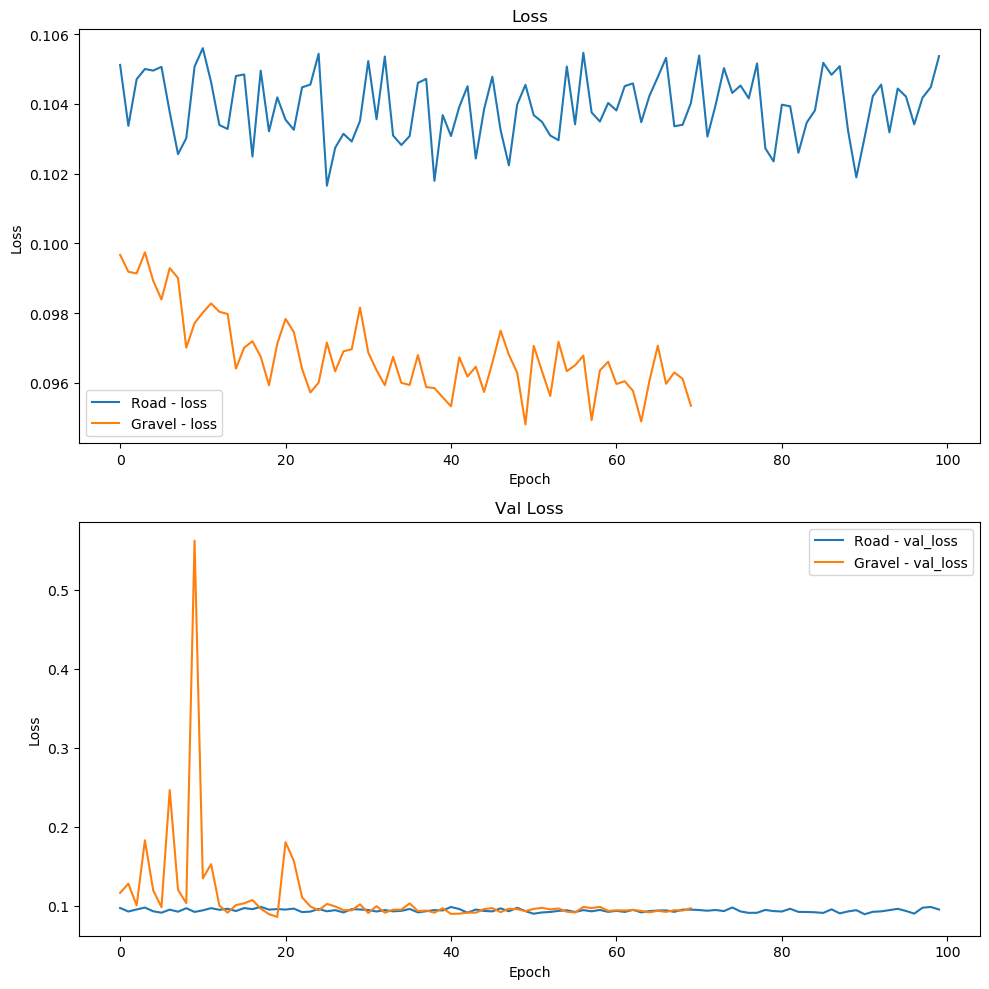

In [7]:
# Configuration
IMG_HEIGHT = 316
IMG_WIDTH = 384
BATCH_SIZE = 16
VAL_SPLIT = 0.2
SEED = 42
USE_EXISTING_MODEL = True

Sections = ["Road","Gravel"]

Section_histories = []

for Section in Sections:
    DATA_DIR = '/home/fizzer/ros_ws/training_for_driving/' + Section + '/images' 
    if USE_EXISTING_MODEL:
        model = tf.keras.models.load_model('/home/fizzer/ros_ws/training_for_driving/'+Section+'/best_model.h5')
    else:
        model = create_model()
    history = Train(model, DATA_DIR, Section)
    Section_histories.append(history)
    
plot_histories(Section_histories, Sections)

In [2]:
def parse_labels(filename):
    # Extract filename from path
    filename_only = tf.strings.split(filename, os.path.sep)[-1]
    
    # Regex pattern to capture Lin and Ang values
    pattern = r'.*_Lin_(-?\d+\.\d{2})_Ang_(-?\d+\.\d{2})\.png$'
    
    # Extract values using regex replace and split
    lin_ang_str = tf.strings.regex_replace(filename_only, pattern, r'\1,\2')
    parts = tf.strings.split(lin_ang_str, ',')
    
    # Convert to floats
    lin = tf.strings.to_number(parts[0], tf.float32)
    ang = tf.strings.to_number(parts[1], tf.float32)
    
    return tf.stack([lin, ang])


In [3]:
def create_dataset(data_dir):
    # List all PNG files
    ds = tf.data.Dataset.list_files(os.path.join(data_dir, "*.png"), shuffle=True)
    
    # Get cardinality as tensor
    cardinality = tf.data.experimental.cardinality(ds)
    
    # Calculate split sizes using TensorFlow operations
    val_size = tf.cast(
        tf.cast(cardinality, tf.float32) * VAL_SPLIT,
        tf.int64
    )
    train_size = cardinality - val_size

    # Split dataset
    train_ds = ds.skip(val_size)
    val_ds = ds.take(val_size)

    # Rest of the processing remains the same...
    def process_path(file_path):
        img = tf.io.read_file(file_path)
        img = tf.io.decode_png(img, channels=3)
        img = tf.image.convert_image_dtype(img, tf.float32)
        return img, parse_labels(file_path)

    train_ds = train_ds.shuffle(10000).map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
    train_ds = train_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    
    val_ds = val_ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
    val_ds = val_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    
    return train_ds, val_ds

In [4]:
def create_model():
    model = models.Sequential([
        layers.Rescaling(1./255, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
        
        # Enhanced convolutional base
        layers.Conv2D(64, (5, 5), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.2),
        
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.3),
        
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.4),
        
        # Dense layers with L2 regularization
        layers.Dense(512, activation='relu', kernel_regularizer='l2'),
        layers.Dense(256, activation='relu', kernel_regularizer='l2'),
        layers.Dense(2, activation='tanh')
    ])
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),  # Lower initial LR
        loss='mse',
        metrics=['mae']
    )
    return model


In [5]:
def Train(model, DATA_DIR, Section):

    train_dataset, val_dataset = create_dataset(DATA_DIR)
    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=50,  # Increased from 10
            min_delta=0.00001,  # Minimum change to qualify as improvement
            mode='min',
            restore_best_weights=True
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=7,  # Wait longer before reducing LR
            verbose=1
        ),
        tf.keras.callbacks.ModelCheckpoint(
            '/home/fizzer/ros_ws/training_for_driving/'+Section+'/best_model.h5',
            save_best_only=True,
            save_weights_only=False,
            monitor='val_loss'
        )
    ]
    
    history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=100,
        callbacks=callbacks,
        verbose=1
    )
    return history

In [6]:
def plot_histories(histories, sections):
    """Dynamically plots loss and accuracy for multiple training histories."""
    
    # Determine available metrics dynamically
    all_metrics = set()
    for history in histories:
        if history is not None:
            all_metrics.update(history.history.keys())

    loss_metrics = [m for m in all_metrics if 'loss' in m]
    acc_metrics = [m for m in all_metrics if 'accuracy' in m or 'acc' in m]

    num_plots = len(loss_metrics) + len(acc_metrics)
    
    # Ensure at least one plot is created
    if num_plots == 0:
        print("No metrics found in histories.")
        return
    
    fig, axs = plt.subplots(num_plots, 1, figsize=(10, 5 * num_plots))
    
    # Convert axs to a list if only one subplot is created
    if num_plots == 1:
        axs = [axs]

    plot_idx = 0
    
    # Plot all loss-related metrics
    for loss_metric in loss_metrics:
        for i, history in enumerate(histories):
            if history is None:
                continue
            label = sections[i]
            axs[plot_idx].plot(history.history[loss_metric], label=f"{label} - {loss_metric}")
        axs[plot_idx].set_title(loss_metric.replace('_', ' ').title())
        axs[plot_idx].set_ylabel("Loss")
        axs[plot_idx].set_xlabel("Epoch")
        axs[plot_idx].legend()
        plot_idx += 1

    # Plot all accuracy-related metrics
    for acc_metric in acc_metrics:
        for i, history in enumerate(histories):
            if history is None:
                continue
            label = sections[i]
            axs[plot_idx].plot(history.history[acc_metric], label=f"{label} - {acc_metric}")
        axs[plot_idx].set_title(acc_metric.replace('_', ' ').title())
        axs[plot_idx].set_ylabel("Accuracy")
        axs[plot_idx].set_xlabel("Epoch")
        axs[plot_idx].legend()
        plot_idx += 1

    plt.tight_layout()
    plt.show()